In [1]:
#импортируем разное
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import matplotlib.pyplot as plt

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


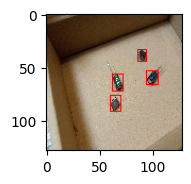

[[ 60  76  70  91]
 [ 62  56  72  72]
 [ 86  33  94  44]
 [ 94  53 105  66]
 [ 60  76  70  91]
 [ 62  56  72  72]
 [ 86  33  94  44]
 [ 94  53 105  66]
 [ 60  76  70  91]
 [ 62  56  72  72]]


In [37]:
#прочитаем запись
dataset = tf.data.TFRecordDataset('bounding_box_dataset.tfrecord')


def parse_record(record):
    #нужно описать приходящий экземпляр
    #имена элементов как при записи
    feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'cords': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, feature_description)
    img = tf.io.parse_tensor(parsed_record['img'], out_type=tf.float32)
    cords = tf.io.parse_tensor(parsed_record['cords'], out_type=tf.float32)
    return img, cords

#пройдемся по записи и распакуем ее
dataset = dataset.map(parse_record)

#еще раз проверим
for i, c in dataset.take(1):
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(3, 1, 1)
    i = i.numpy()
    c = c.numpy()
    c = (c+1)/2*128 #обратно из от -1...1 к 0...64
    c = c.astype(np.int16)  #для opencv
    for bb in c:
        i = cv2.rectangle(i ,(bb[0] ,bb[1] ),(bb[2], bb[3]),(1,0,0),1)
    plt.imshow(i)
    plt.show()
    print(c)

dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(32).shuffle(40)

In [11]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, Conv2DTranspose, Concatenate, LeakyReLU, Dropout

#давайте напишем нейросеть

inputs = Input((128,128,3))
x = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
x = Conv2D(64, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(64, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(256, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(30)(x)  #3*10 = 30 у нейросети это просто выходы подряд

outputs = x

boxregressor = keras.Model(inputs, outputs)

In [12]:
def IoU_Loss(true, pred):
    #(32, 5, 4)
    t1 = true
    t2 = pred
    
    minx1, miny1, maxx1, maxy1 = tf.split(t1, 4, axis = 2)
  
    fminx, miny2, fmaxx = tf.split(t2, 3, axis = 2)
    
    minx2 = tf.minimum(fminx, fmaxx)
    maxx2 = tf.maximum(fminx, fmaxx)
    
    delta = maxx2 - minx2
    
    maxy2 = miny2 + delta
    
    
    intersection = 0.0 
    
    #найдем пересечение каждого из предсказанных с каждым из реальных
    #сложим все вместе
    for i1 in range(10):
        for i2 in range(10):
            x_overlap = tf.maximum(0.0, tf.minimum(maxx1[:,i1], maxx2[:,i2]) - tf.maximum(minx1[:,i1], minx2[:,i2]))
            y_overlap = tf.maximum(0.0, tf.minimum(maxy1[:,i1], maxy2[:,i2]) - tf.maximum(miny1[:,i1], miny2[:,i2]))
            intersection += x_overlap*y_overlap
            
    #с несколькими обьектами сложнее. Мы не можем просто найди обьединение трех и более прямоугольников по координатам
    #пойдем на некоторые хитрости.
    #не будем считасть обьединение и сравнивать его с пересечение как в IoU
    #а будем стремится сделать площади всех элементов такими-же, как у реальных рамок 
    #просто среднеквадратичной ошибкой
            
    beta1 = 0.0
    for i1 in range(10):
        for i2 in range(10):
            x_overlap = tf.maximum(0.0, tf.minimum(maxx1[:,i1], maxx1[:,i2]) - tf.maximum(minx1[:,i1], minx1[:,i2]))
            y_overlap = tf.maximum(0.0, tf.minimum(maxy1[:,i1], maxy1[:,i2]) - tf.maximum(miny1[:,i1], miny1[:,i2]))
            if i1 == i2:
                beta1 += (x_overlap*y_overlap)**2
            else:
                beta1 += x_overlap*y_overlap
                
    
                
    beta2 = 0.0
    for i1 in range(10):
        for i2 in range(10):
            x_overlap = tf.maximum(0.0, tf.minimum(maxx2[:,i1], maxx2[:,i2]) - tf.maximum(minx2[:,i1], minx2[:,i2]))
            y_overlap = tf.maximum(0.0, tf.minimum(maxy2[:,i1], maxy2[:,i2]) - tf.maximum(miny2[:,i1], miny2[:,i2]))
            if i1 == i2:
                beta2 += (x_overlap*y_overlap)**2
            else:
                beta2 += x_overlap*y_overlap
                
    
    loss = (beta1 - beta2)**2 - intersection
    
    return loss

    


In [32]:
class Model(tf.keras.Model):
    def __init__(self, nn_box):
        super(Model, self).__init__()
        self.nn_box = nn_box
        
        self.box_optimizer = tf.keras.optimizers.Adam(3e-4, clipnorm = 1.0)
        
    @tf.function
    def training_step(self, x, true_boxes):
        
        with tf.GradientTape() as tape_box:
            
            pred = self.nn_box(x, training=True)
            pred = tf.reshape(pred, [-1, 10, 3])

            loss = IoU_Loss(true_boxes, pred)   
      #      print('test', tf.reduce_mean(IoU_Loss(true_boxes, true_boxes) ))

        # Backpropagation.
        grads = tape_box.gradient(loss, self.nn_box.trainable_variables)
        self.box_optimizer.apply_gradients(zip(grads, self.nn_box.trainable_variables))

        return loss
    
model = Model(boxregressor)

In [ ]:
for i, c in dataset.take(1):
    print(tf.reduce_mean(model.training_step(i, c)))

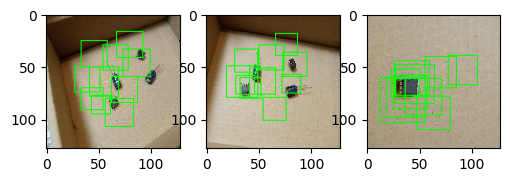

In [43]:
#проверка работы
def testing():
    for ii, cc in dataset.take(1):
        #обрабатывем целый батч, используем только пять элементов
        pred = model.nn_box(ii)
        plt.figure(figsize=(10, 6))
        
        for num in range(3):
            i = ii[num]
            
            pred = tf.reshape(pred, [-1, 10, 3])
            c = pred[num]

            ax = plt.subplot(1, 5, num+1)
            #переход в numpy для работы в opencv
            i = i.numpy()
            c = c.numpy()
            c = (c+1)/2*128 #обратно из от -1...1 к 0...64
            c = c.astype(np.int16)  #для opencv
            for bb in c:
                bb0 = min(bb[0] ,bb[2])
                bb2 = max(bb[0] ,bb[2])
                i = cv2.rectangle(i ,(bb0 ,bb[1] ),(bb2, bb[1] + (bb2- bb0)),(0,1,0),1)
            plt.imshow(i)
            
        plt.show()
       # print(c)
        
testing()

100


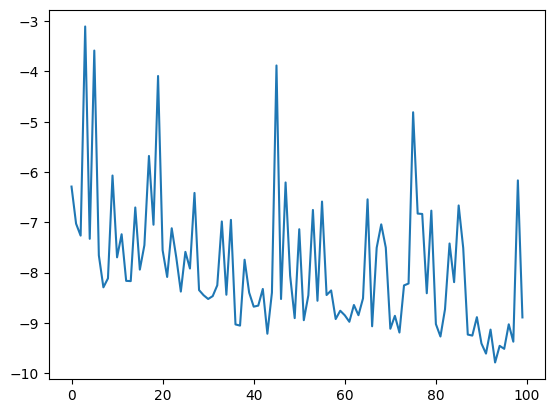

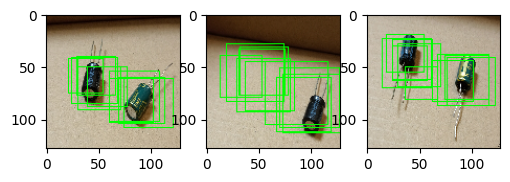

In [39]:
from IPython.display import clear_output
hist = np.array(np.empty([0]))
epochs = 100
ff = 0
for epoch in range(1, epochs + 1):
    loss = 0
    lc = 0
    for step, (i, c) in enumerate(dataset):
        loss+=tf.reduce_mean(model.training_step(i,c))
        lc+=1
    clear_output(wait=True)
    print(epoch)
    hist = np.append(hist, loss/lc)
 
    plt.plot(np.arange(0,len(hist)), hist)
    plt.show()
    testing()

In [44]:
#сохранить
model.nn_box.save('my_bb_model.h5')

In [14]:
#загрузить веса
model.nn_box.load_weights('base_model_2.h5')